# DEMO 5

Applying an RL model to a historical stock market dataset

In [6]:
import sys
import os

# Manually set the path relative to the py file's location that you want to import
func_lib_path = os.path.abspath(os.path.join(os.getcwd(), '../'))# Add the path to sys.path
sys.path.append(func_lib_path)

# Now you can import func_lib
import func_lib
import random
import numpy as np
import pandas as pd
import gymnasium as gym
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
from gymnasium import spaces
import matplotlib.pyplot as plt

In [ ]:
historical_prices = func_lib.createHistPrices()
cutoff_date = pd.to_datetime('2022-10-10')
historical_prices= historical_prices[historical_prices.index.get_level_values('Date') >cutoff_date]
list_of_momentums = [1, 5, 15, 20]
total_returns     = func_lib.computingReturns(historical_prices, list_of_momentums)
total_returns.dropna(inplace=True)

In [7]:
total_returns.head()

F_1_d_returns  1_d_returns  5_d_returns  15_d_returns  \
Ticker Date                                                                
A      2022-11-08      -0.012612     0.005216    -0.015189      0.048753   
       2022-11-09       0.067883    -0.012612     0.012789      0.062345   
       2022-11-10       0.013739     0.067883     0.088056      0.161664   
       2022-11-11      -0.013013     0.013739     0.089874      0.141900   
       2022-11-14       0.011067    -0.013013     0.060494      0.106425   

                   20_d_returns  
Ticker Date                      
A      2022-11-08      0.104346  
       2022-11-09      0.089983  
       2022-11-10      0.143862  
       2022-11-11      0.179873  
       2022-11-14      0.121170

In [8]:
# Converting the 'F_1_d_returns' to binary based on whether the value is positive or not
total_returns['F_1_d_returns_Ind'] = total_returns['F_1_d_returns'].apply(lambda x: 1 if x > 0 else 0)
total_returns.head()

F_1_d_returns  1_d_returns  5_d_returns  15_d_returns  \
Ticker Date                                                                
A      2022-11-08      -0.012612     0.005216    -0.015189      0.048753   
       2022-11-09       0.067883    -0.012612     0.012789      0.062345   
       2022-11-10       0.013739     0.067883     0.088056      0.161664   
       2022-11-11      -0.013013     0.013739     0.089874      0.141900   
       2022-11-14       0.011067    -0.013013     0.060494      0.106425   

                   20_d_returns  F_1_d_returns_Ind  
Ticker Date                                         
A      2022-11-08      0.104346                  0  
       2022-11-09      0.089983                  1  
       2022-11-10      0.143862                  1  
       2022-11-11      0.179873                  0  
       2022-11-14      0.121170                  1

In [9]:
# Determine the split index for 70% of the dates
unique_dates = total_returns.index.get_level_values('Date').unique()
split_date = unique_dates[int(0.7 * len(unique_dates))]
split_date

Timestamp('2023-11-17 00:00:00')

In [10]:
# Create the training set: all data before the split date
train_data = total_returns.loc[total_returns.index.get_level_values('Date') < split_date]

# Create the testing set: all data from the split date onwards
test_data = total_returns.loc[total_returns.index.get_level_values('Date') >= split_date]

In [11]:
total_returns  = test_data['F_1_d_returns']

In [12]:
features = ['1_d_returns', '5_d_returns', '15_d_returns', '20_d_returns']
target   = ['F_1_d_returns_Ind']

# Split the data into training and testing sets
X_train = train_data[features]
X_test  = test_data[features]
y_train = train_data[target]
y_test  = test_data[target]

In [13]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled  = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

In [ ]:
# Define the custom gym environment
class ReturnEnv(gym.Env):
    def __init__(self, df):
        super(ReturnEnv, self).__init__()
        
        # Define action and observation space
        self.action_space = spaces.Discrete(2)  # 0 or 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(4,), dtype=np.float32)
        
        # Initialize dataframe
        self.df = df.reset_index()
        self.current_step = 0
        
    def reset(self):
        self.current_step = 0
        state = self.df.iloc[self.current_step][['1_d_returns', '5_d_returns', '15_d_returns', '20_d_returns']].values
        return state
    
    def step(self, action):
        target = self.df.iloc[self.current_step]['F_1_d_returns_Ind']
        
        # Reward if action matches target return
        reward = 1 if action == target else -1
        
        self.current_step += 1
        done = self.current_step >= len(self.df)
        
        if not done:
            next_state = self.df.iloc[self.current_step][['1_d_returns', '5_d_returns', '15_d_returns', '20_d_returns']].values
        else:
            next_state = np.zeros(4)
        
        return next_state, reward, done, {}

In [14]:
# Q-learning Agent
class QLearningAgent:
    def __init__(self, action_space, state_space, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.action_space = action_space
        self.state_space = state_space
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = epsilon  # exploration rate
        self.q_table = defaultdict(lambda: np.zeros(action_space.n))
    
    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return self.action_space.sample()  # explore
        else:
            return np.argmax(self.q_table[str(state)])  # exploit
    
    def update(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[str(next_state)])
        td_target = reward + self.gamma * self.q_table[str(next_state)][best_next_action]
        td_error = td_target - self.q_table[str(state)][action]
        self.q_table[str(state)][action] += self.alpha * td_error

In [21]:
def trading_strategy(y_pred):
    if y_pred > 0.5:
        return  1 # Go long
    else:
        return  0  
    

In [ ]:
def main():
 
    train_df  = pd.merge(y_train, X_train_scaled, left_index=True, right_index=True)
    test_df   = pd.merge(y_test,  X_test_scaled,  left_index=True, right_index=True)

    train_df.index.names = ['Ticker', 'Date']
    test_df.index.names = ['Ticker', 'Date']



    # Create environment and agent for training
    env = ReturnEnv(train_df)
    agent = QLearningAgent(env.action_space, env.observation_space)

    # Training loop
    n_episodes = 1000
    for episode in range(n_episodes):
        state = env.reset()
        done = False
        
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.update(state, action, reward, next_state)
            state = next_state

    print("Training finished.")

    # Print predictions for training data and add them back to df
    train_df = print_predictions(env, agent, train_df, "training")

    # Create environment for evaluation
    eval_env = ReturnEnv(test_df)

    # Print predictions for evaluation data and add them back to test_df
    test_df = print_predictions(eval_env, agent, test_df, "evaluation")

    print("\nTraining Data with Predictions:")
     
    
    print("\nEvaluation Data with Predictions:")
    print(test_df)
    train_df.to_csv('train.csv')
    test_df.to_csv('test.csv')



In [ ]:
def print_predictions(env, agent, df, dataset_name):
    state = env.reset()
    done = False
    step = 1
    predictions = []

    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        
        # Record prediction details
        predictions.append((env.current_step - 1, action, reward, state, next_state))

        state = next_state
        step += 1
    
    # Print predictions
    #print(f"\nPredictions for {dataset_name} data:")
    for idx, action, reward, state, next_state in predictions:
        #print(f"Action: {action}, Target Return: {env.df.loc[idx]['F_1_d_returns_Ind']}, Reward: {reward}, Step: {step}, State: {state}, Next State: {next_state}")
        pass
    # Add predictions to DataFrame
    pred_df = pd.DataFrame(predictions, columns=['Index', 'Action', 'Reward', 'State', 'Next_State'])
    pred_df = pred_df.set_index('Index')
    df = df.reset_index().merge(pred_df[['Action']], left_index=True, right_index=True, how='left').set_index(['Ticker', 'Date'])
    return df

In [ ]:
if __name__ == "__main__":
    main()

In [15]:
y_test_and_pred = pd.read_csv('test.csv')

In [16]:
model_name = 'RL-Model'

In [17]:
y_test_and_pred['Date'] = pd.to_datetime(y_test_and_pred['Date'])
y_test_and_pred.set_index(['Ticker', 'Date'], inplace=True)
y_test_and_pred.rename(columns={'Action':model_name}, inplace=True)

In [18]:
y_test_and_pred = pd.merge(y_test_and_pred, total_returns, left_index=True, right_index=True, how='inner')

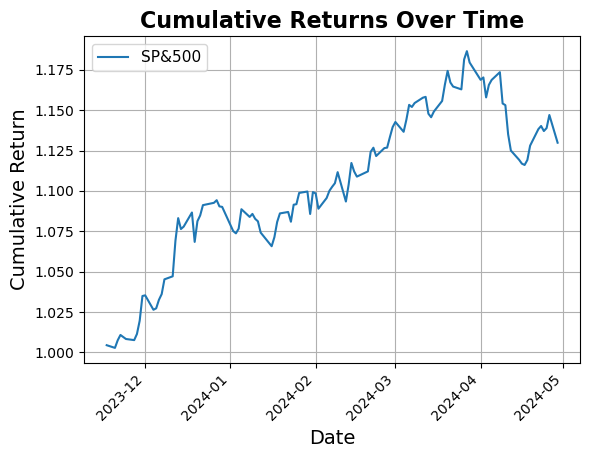

The CAGR is: 31.11%
Sharpe Ratio of Strategy: 2.47


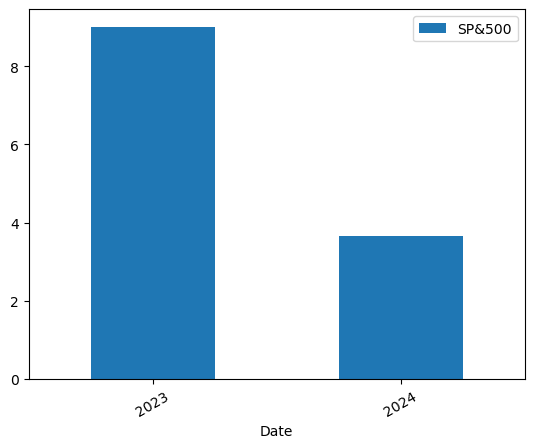

In [19]:
cum_returns, calendar_returns = func_lib.compute_BM_Perf(y_test_and_pred)

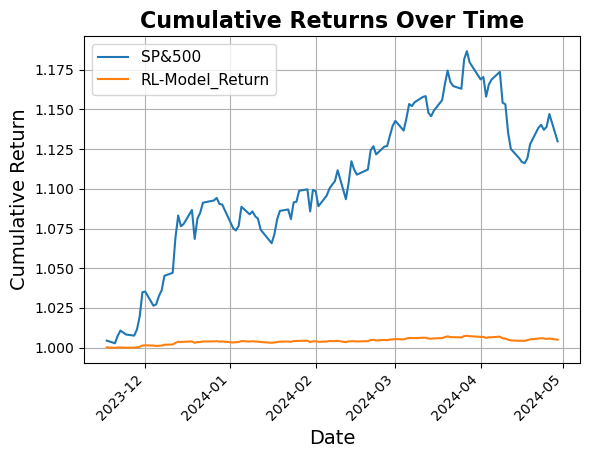

The CAGR is: 1.17%
Sharpe Ratio of Strategy: 1.93


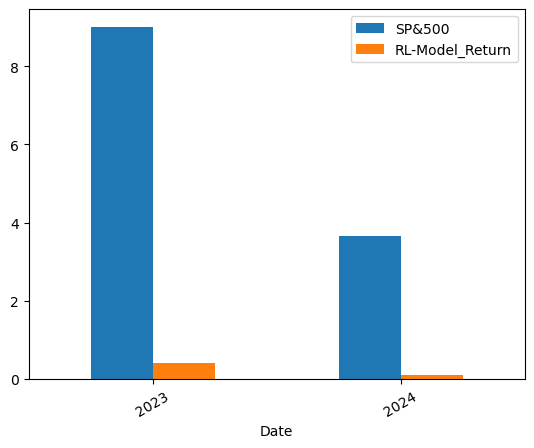

In [22]:
cum_returns, calendar_returns = func_lib.compute_strat_perf(y_test_and_pred, cum_returns, calendar_returns, trading_strategy, model_name)